## Automated Error Analysis

This notebook uses LLMs to analyze and summarize the errors in the eval results across a single common dataset.

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import os
from openai import OpenAI
import os
import json
import warnings
from eval.eval import get_all_minimal_queries
warnings.filterwarnings('ignore')

from defog_utils.utils_sql import SqlFeatures, get_sql_features

openai = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
model_4_latest = "gpt-4o"

### 1. Extract all results for a single dataset name

In [2]:
results_dir_path = f"results/sqlcoder_8b_fullft_ds_003_llama3_mgn1_b1_0900_b2_0990"
keyword = "api" # Provide the dataset name e.g. 001, 002 etc

In [3]:
def list_csv_files(path):
    # Get all file names in the directory
    file_names = os.listdir(path)

    # Filter for only .csv files
    csv_files = [f for f in file_names if f.endswith('.csv')]

    # Sort files alphabetically
    csv_files.sort()

    # Create dictionary with numbered keys
    csv_dict = {i: csv_files[i] for i in range(len(csv_files))}

    return csv_dict

csv_files = list_csv_files(results_dir_path)
print(f"{len(csv_files)} CSV files found in the directory")

56 CSV files found in the directory


In [4]:
# Get indices of csv_files with these keywords
keywords = [keyword]
keywords_to_exclude = []
selected_models = [i for i, s in enumerate(csv_files.values()) if all(xs in s for xs in keywords)]
if keywords_to_exclude:
    selected_models = [i for i in selected_models if not any(xs in csv_files[i] for xs in keywords_to_exclude)]

# Print selected models
print("Results to analyze:")
for i in selected_models:
    print(f"{csv_files[i]}")

# Load results from csv file into dataframe
dfs = {}
for id in selected_models:
    file_name = csv_files[id]
    model = file_name.replace('.csv', '')
    csv_path = os.path.join(results_dir_path, file_name)
    dfs[model] = pd.read_csv(csv_path, comment='#')

Results to analyze:
c1000_api_advanced.csv
c1000_api_advanced_cot.csv
c1000_api_basic.csv
c1000_api_basic_cot.csv
c1000_api_idk.csv
c1000_api_idk_cot.csv
c1000_api_v1.csv
c1000_api_v1_cot.csv
c400_api_advanced.csv
c400_api_advanced_cot.csv
c400_api_basic.csv
c400_api_basic_cot.csv
c400_api_idk.csv
c400_api_idk_cot.csv
c400_api_v1.csv
c400_api_v1_cot.csv
c500_api_advanced.csv
c500_api_advanced_cot.csv
c500_api_basic.csv
c500_api_basic_cot.csv
c500_api_idk.csv
c500_api_idk_cot.csv
c500_api_v1.csv
c500_api_v1_cot.csv
c600_api_advanced.csv
c600_api_advanced_cot.csv
c600_api_basic.csv
c600_api_basic_cot.csv
c600_api_idk.csv
c600_api_idk_cot.csv
c600_api_v1.csv
c600_api_v1_cot.csv
c700_api_advanced.csv
c700_api_advanced_cot.csv
c700_api_basic.csv
c700_api_basic_cot.csv
c700_api_idk.csv
c700_api_idk_cot.csv
c700_api_v1.csv
c700_api_v1_cot.csv
c800_api_advanced.csv
c800_api_advanced_cot.csv
c800_api_basic.csv
c800_api_basic_cot.csv
c800_api_idk.csv
c800_api_idk_cot.csv
c800_api_v1.csv
c800_api

In [5]:
#Combine all dataframes of selected models into one
all_dfs = []
for model in dfs:
    temp_df = dfs[model]
    temp_df['model'] = model
    all_dfs.append(temp_df)
df = pd.concat(all_dfs)
# Apply get_all_minimal_queries to all queries
df['true_queries'] = df['query'].apply(get_all_minimal_queries)
df['error_msg_short'] = df['error_msg'].str.split("\n\n").str[0].str.replace("QUERY EXECUTION ERROR:", "")

# Split model column by the last underscore 
df['eval'] = df['model'].str.rsplit(pat='_', n=1).str[1]
df['model'] = df['model'].str.rsplit(pat='_', n=1).str[0]
df.head(1)


,db_name,query_category,question,instructions,query,full_instructions,db_type,generated_query,reason,error_msg,...,question_0,query_0,question_1,query_1,cot_instructions,logprobs,model,true_queries,error_msg_short,eval
0,broker,instructions_cte_join,"For customers with at least 5 total transactions, what is their transaction success rate? Return the customer name and success rate, ordered from lowest to highest success rate.","\nFollow the instructions below to generate the query:\nTo get the success rate of transactions per customer, join customer and transaction tables, group by customer, and calculate the percentage of successful transactions.\n","WITH cust_tx_stats AS (SELECT c.sbCustId, c.sbCustName, COUNT(t.sbTxId) AS total_tx, SUM(CASE WHEN t.sbTxStatus = 'success' THEN 1 ELSE 0 END) AS success_tx FROM sbCustomer c JOIN sbTransaction t ON c.sbCustId = t.sbTxCustId GROUP BY c.sbCustId, c.sbCustName) SELECT sbCustName, success_tx::float/total_tx AS success_rate FROM cust_tx_stats WHERE total_tx >= 5 ORDER BY success_rate","CR = customer rank by total transaction amount, with different rankings based on transaction amounts MoMC = month-over-month change in average closing price based on previous month's averages for each ticker each month To get the success rate of transactions per customer, join customer and transaction tables, group by customer, and calculate the percentage of successful transactions. Always join transactions with customers before using the transactions table. TAC = Total Active Customers who joined after a certain date",postgres,"WITH customer_transactions AS ( SELECT c.sbCustName, t.sbTxStatus FROM sbCustomer c JOIN sbTransaction t ON c.sbCustId = t.sbTxCustId ) SELECT ct.sbCustName, CAST ( SUM ( CASE WHEN ct.sbTxStatus = 'success' THEN 1 ELSE 0 END ) AS FLOAT ) / NULLIF ( COUNT ( ct.sbTxStatus ) , 0 ) AS success_rate FROM customer_transactions ct GROUP BY ct.sbCustName HAVING COUNT ( ct.sbTxStatus ) >= 5 ORDER BY success_rate ASC;",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[],c1000_api,"[WITH cust_tx_stats AS (SELECT c.sbCustId, c.sbCustName, COUNT(t.sbTxId) AS total_tx, SUM(CASE WHEN t.sbTxStatus = 'success' THEN 1 ELSE 0 END) AS success_tx FROM sbCustomer c JOIN sbTransaction t ON c.sbCustId = t.sbTxCustId GROUP BY c.sbCustId, c.sbCustName) SELECT sbCustName, success_tx::float/total_tx AS success_rate FROM cust_tx_stats WHERE total_tx >= 5 ORDER BY success_rate]",NaN,advanced


### 2. Analyze Correctness
#### 2.1 Compute Correctness by Category

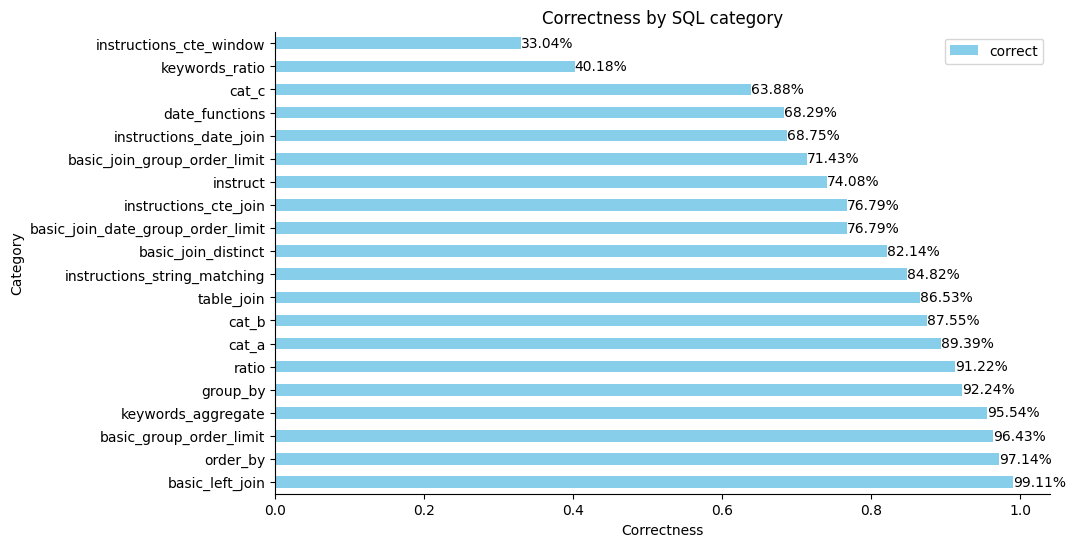

In [6]:
# Plot the correctness by category
df_category_correct = df.pivot_table("correct", "query_category", aggfunc="mean").sort_values('correct', ascending=False)
df_category_correct.plot(kind='barh', color='skyblue', figsize=(10, 6))
plt.title('Correctness by SQL category')
plt.xlabel('Correctness')
plt.ylabel('Category')
# add labels
for i, v in enumerate(df_category_correct['correct']):
    plt.text(v, i, f"{v*100:.2f}%", color='black', va='center')
ax = plt.gca()
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
plt.show()

In [7]:
# Convert df to dict
category_corr_dict = df_category_correct.sort_values('correct', ascending=True).to_dict()['correct']
category_corr_dict

{'instructions_cte_window': 0.33035714285714285,
 'keywords_ratio': 0.4017857142857143,
 'cat_c': 0.6387755102040816,
 'date_functions': 0.6828571428571428,
 'instructions_date_join': 0.6875,
 'basic_join_group_order_limit': 0.7142857142857143,
 'instruct': 0.7408163265306122,
 'instructions_cte_join': 0.7678571428571429,
 'basic_join_date_group_order_limit': 0.7678571428571429,
 'basic_join_distinct': 0.8214285714285714,
 'instructions_string_matching': 0.8482142857142857,
 'table_join': 0.8653061224489796,
 'cat_b': 0.8755102040816326,
 'cat_a': 0.8938775510204081,
 'ratio': 0.9122448979591836,
 'group_by': 0.9224489795918367,
 'keywords_aggregate': 0.9553571428571429,
 'basic_group_order_limit': 0.9642857142857143,
 'order_by': 0.9714285714285714,
 'basic_left_join': 0.9910714285714286}

#### 2.2 Compute Correctness by SQL Features

We parse the expected query to get its features and see which features are more error-prone.

In [8]:
df["sql_features"] = df["query"].apply(lambda x: get_sql_features(x).to_dict())
df_sql_features = pd.json_normalize(df["sql_features"])
# add correct column
df_sql_features["correct"] = df["correct"].reset_index(drop=True)
df_sql_features.head(1)

,sql_num_columns,sql_num_tables,sql_table_alias,sql_joins,sql_join_same,sql_join_left,sql_has_null,sql_distinct,sql_cte,sql_union,...,sql_generate_timeseries,sql_string_concat,sql_string_exact_match,sql_string_case_insensitive_match,sql_string_like_match,sql_string_ilike_match,sql_string_substring,sql_string_regex,sql_sorry,correct
0,8,3,True,1,False,False,False,False,1,False,...,False,False,True,False,False,False,False,False,False,1


<Axes: >

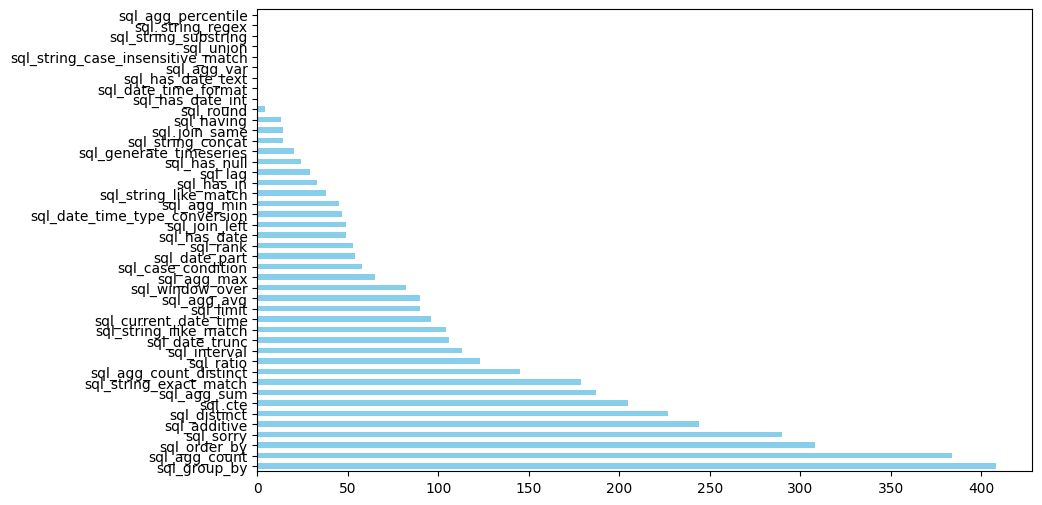

In [9]:
# for all the wrong queries, sum up each column
df_sql_features_wrong = df_sql_features[df_sql_features["correct"] == 0]
df_sql_features_wrong = df_sql_features_wrong.drop(columns=["correct", "sql_num_tables", "sql_num_columns", "sql_joins", "sql_table_alias"])
df_sql_features_wrong_sum = df_sql_features_wrong.sum().sort_values(ascending=False)
df_sql_features_wrong_sum.plot(kind='barh', color='skyblue', figsize=(10, 6))

In [10]:
# get the correct/incorrect counts for each feature
df_sql_features_correct = df_sql_features.groupby('correct').sum().T
df_sql_features_correct

correct,0,1
sql_num_columns,3482,12249
sql_num_tables,1659,5840
sql_table_alias,357,931
sql_joins,730,2107
sql_join_same,14,14
sql_join_left,49,175
sql_has_null,24,200
sql_distinct,227,776
sql_cte,205,243
sql_union,0,0


The above counts are univariate, which isn't very helpful. The next step is to see how groups of these features perform poorly together.

For example, sql_date_part + sql_case_condition + sql_joins > 1 fail the most times, then we can know and generate more of such data.

### 3. Analyze invalid SQL with DB exec errors

In [18]:
# Get db exec error rows across all result files
df_error_exec = df[df['error_db_exec'] == 1][['model', 'db_name', 'question', 'error_db_exec', 'error_msg_short', 'true_queries', 'generated_query']].sort_values(['db_name','question'])
# Get questions with recurring exec errors
df_error_exec_recurr = df_error_exec[df_error_exec.duplicated(subset=['db_name', 'question'], keep=False)][['question', 'error_db_exec', 'error_msg_short', 'true_queries', 'generated_query']]
print(f"{len(df_error_exec_recurr['question'].unique())} questions with recurring exec errors")
df_error_exec_recurr.head(2)

44 questions with recurring exec errors


,question,error_db_exec,error_msg_short,true_queries,generated_query
21,How does the ratio of publications to journals change over the years? Return the annual numbers of publications and journals as well.,1,"(psycopg2.errors.UndefinedColumn) column j.year does not exist\nLINE 1: ...p GROUP BY p.year ) , yearly_journals AS ( SELECT j.year, CO...\n ^","[SELECT publication.year, COUNT(DISTINCT publication.pid) AS num_publications, COUNT(DISTINCT publication.jid) AS num_journals, CAST(COUNT(DISTINCT publication.pid) AS FLOAT) / NULLIF(COUNT(DISTINCT publication.jid), 0) AS ratio FROM publication GROUP BY publication.year ORDER BY publication.year]","WITH yearly_publications AS ( SELECT p.year, COUNT ( p.pid ) AS num_publications FROM publication p GROUP BY p.year ) , yearly_journals AS ( SELECT j.year, COUNT ( j.jid ) AS num_journals FROM journal j GROUP BY j.year ) SELECT yp.year, yp.num_publications, yj.num_journals, CAST ( yp.num_publications AS FLOAT ) / NULLIF ( yj.num_journals, 0 ) AS publication_to_journal_ratio FROM yearly_publications yp JOIN yearly_journals yj ON yp.year = yj.year ORDER BY yp.year NULLS LAST;"
21,How does the ratio of publications to journals change over the years? Return the annual numbers of publications and journals as well.,1,"(psycopg2.errors.UndefinedColumn) column j.year does not exist\nLINE 1: ...p GROUP BY p.year ) , yearly_journals AS ( SELECT j.year, CO...\n ^","[SELECT publication.year, COUNT(DISTINCT publication.pid) AS num_publications, COUNT(DISTINCT publication.jid) AS num_journals, CAST(COUNT(DISTINCT publication.pid) AS FLOAT) / NULLIF(COUNT(DISTINCT publication.jid), 0) AS ratio FROM publication GROUP BY publication.year ORDER BY publication.year]","WITH yearly_publications AS ( SELECT p.year, COUNT ( p.pid ) AS num_publications FROM publication p GROUP BY p.year ) , yearly_journals AS ( SELECT j.year, COUNT ( j.jid ) AS num_journals FROM journal j GROUP BY j.year ) SELECT yp.year, yp.num_publications, yj.num_journals, CAST ( yp.num_publications AS FLOAT ) / NULLIF ( yj.num_journals, 0 ) AS publication_to_journal_ratio FROM yearly_publications yp JOIN yearly_journals yj ON yp.year = yj.year ORDER BY yp.year NULLS LAST;"


In [ ]:
# Convert error_msg_short col to a string of bullet points
error_exec_str = "\n".join([f"- {x}" for x in df_error_exec_recurr['error_msg_short']])

Extract patterns from db execution error messages

In [ ]:
# Get error exec patterns
def get_error_exec_patterns(
    model: str, error_exec_str: str
) -> str:
    """
    Use LLM to extract recurring patterns in a list of error messages.
    """
    messages = [
        {
            "role": "system",
            "content": f"""Your task is to identify recurring patterns in the error messages below and provide a summary of the patterns."""
        },
        {
            "role": "user",
            "content": f"""List of error messages:
{error_exec_str}

Format your response as a numbered list of recurring patterns in the error messages. 
Each point should be a concise yet detailed summary of a trend identified in the error messages along with specific examples.
Do not include any other information before and after the list.
""",
        },
    ]

    completion = openai.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=1000,
        temperature=0,
        # top_p=0.5,
        # response_format = {"type": "json_object"}
    )
    completion = completion.choices[0].message.content
    return completion

In [ ]:
error_exec_summary = get_error_exec_patterns(model_4_latest, error_exec_str)
print(error_exec_summary)

### 4. Analyze valid but wrong examples

In [ ]:
# Get valid but correct examples across all result files
df_valid_wrong = df[(df['correct'] == 0) & (df['error_db_exec'] == 0)][['model', 'db_name', 'query_category', 'question', 'instructions', 'correct', 'error_db_exec', 'true_queries', 'generated_query']].sort_values(['db_name','question']).fillna('')
# Get questions that were repeatedly valid but wrong
df_valid_wrong_recurr = df_valid_wrong[df_valid_wrong.duplicated(subset=['db_name', 'question'], keep=False)][['db_name', 'query_category', 'question', 'instructions', 'true_queries', 'generated_query']]
print(f"{len(df_valid_wrong_recurr['question'].unique())} unique questions that are recurring valid but wrong")
df_valid_wrong_recurr.head(3)

In [ ]:
# Get first row of all duplicates
# To reduce the number of LLM calls, we will assume that all duplicates are wrong in the same way
df_valid_wrong_recurr_first = df_valid_wrong_recurr.drop_duplicates(subset=['db_name', 'question'], keep='first')[['query_category', 'question', 'instructions', 'true_queries', 'generated_query']]
df_valid_wrong_recurr_first.head(4)

In [ ]:
# Get reasons for valid but wrong examples
def explain_incorrect(
    model: str, question: str, instructions: str, true_sqls: list, generated_sql: str
) -> str:
    """
    Use LLM to explain why a SQL query is incorrect given a question, instructions and the true SQL queries.
    """
    if instructions:
        instructions = f"\nInstructions: {instructions}\n"
    messages = [
        {
            "role": "system",
            "content": f"""Your task is to explain why the SQL query is incorrect given the question, instructions and the true SQL queries."""
        },
        {
            "role": "user",
            "content": f"""Question: {question}{instructions}
Incorrect SQL: {generated_sql}

True SQL queries:
{true_sqls}

Format your response as a valid JSON string with reason as a key. 
Your response should look like the string below:
{{ "reason": "Your reasoning for why the SQL query is incorrect according to the question and the true SQL queries."
}}

Do not include any other information before and after the JSON string.
""",
        },
    ]

    completion = openai.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=500,
        temperature=0,
        # top_p=0.5,
        response_format = {"type": "json_object"}
    )
    completion = completion.choices[0].message.content
    try:
        completion_dict = json.loads(completion)
    except:
        print(f"Error parsing completion {completion}", flush=True)
        completion_dict = {"reason": None}
    reason = completion_dict.get("reason", None)
    return reason

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()
# Get explanations for valid but wrong examples
df_valid_wrong_recurr_first['reason_incorrect'] = df_valid_wrong_recurr_first.progress_apply(lambda x: explain_incorrect(model_4_latest, x['question'], x['instructions'], x['true_queries'], x['generated_query']), axis=1)
df_valid_wrong_recurr_first

In [ ]:
# Convert reason_incorrect col to a string of bullet points
reason_incorrect_str = "\n".join([f"- {x}" for x in df_valid_wrong_recurr_first['reason_incorrect']])

Get recurring patterns from reasons of valid but wrong examples.

In [ ]:
# Get reasons for valid but wrong examples
def get_valid_wrong_patterns(
    model: str, reason_incorrect_str: str
) -> str:
    """
    Use LLM to extract recurring patterns in a list of error messages that describe why a SQL query is wrong according to the question and the true SQL queries.
    """
    messages = [
        {
            "role": "system",
            "content": f"""Your task is to identify recurring patterns in the error messages below and provide a summary of the patterns."""
        },
        {
            "role": "user",
            "content": f"""List of error messages that describe why a SQL query is wrong according to the question and the true SQL queries:
{reason_incorrect_str}

Format your response as a numbered list of recurring patterns in the error messages. 
Each point should be a concise yet detailed summary of a trend identified in the error messages along with specific examples (e.g. inability to follow instructions, common errors in specific SQL categories, etc.).
Do not include any other information before and after the list.
""",
        },
    ]

    completion = openai.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=1000,
        temperature=0,
        # top_p=0.5,
        # response_format = {"type": "json_object"}
    )
    completion = completion.choices[0].message.content
    return completion

In [ ]:
valid_wrong_summary = get_valid_wrong_patterns(model_4_latest, reason_incorrect_str)
print(valid_wrong_summary)

In [19]:
# Store summaries in a json file
summary_dict = {
    "category_corr_dict": category_corr_dict,
    "error_exec_summary": error_exec_summary,
    "valid_wrong_summary": valid_wrong_summary
}
output_file = f"{results_dir_path}error_analysis_ds_{ds_to_analyze}.json"
with open(output_file, 'w') as f:
    json.dump(summary_dict, f, indent=4)